### Проблема

Оцените риск неуплаты клиента по кредиту (дефолт).
Нужная модель позволяет банку или другой кредитной организации оценить
текущий риск по любым выданным займам и кредитным продуктам 
и с большей долей вероятности предотвратить неисполнение кредитных
обязательств клиентом. Таким образом, банк меньше рискует понести
убытки.

## Результаты

1. В результате получен пробный датафрейм, состоящий из признаков для обучения модели.
2. В качестве признаков использованы значения всех категориальных переменных при использовании OneHotEncoder (с дальнешим агрегированием по id, в качестве агр.функции использовалась sum()), меньшее количество не использовалось, т.к. даже не особо значимые фичи дают прирост качества модели. Другого способа преобразовать фрейм с имеющимся объемом оперативной памяти не представляется возможным.
3. Размер результирующего фрейма:(3000000, 478)
4. Лучшая модель с гиперпараметрами LGBMClassifier(class_weight='balanced', early_stopping_rounds = 500, verbose=-1, n_jobs=8, objective='binary', metric='auc', learning_rate=0.05, max_depth=20, n_estimators=1000, num_leaves=100). Всего было проверено 3 модели. Соотношение тренировочной и тествой выборки составляет 80(2700000, 478)/20(300000, 478). Метрика ROC-AUC при этом train=0.8, test=0.763.
5. Подготовлен пайплайн с помощью sklearn.pipeline, реализованы fit и predict. Модель обучена и сохранена в бинарном файле pickle.  Метрика ROC-AUC на всем фрейме = 0.82

# Решение 

## 1.Business Understanding

- Краткое описание задачи
  
Предсказание выхода клиента в дефолт по кредиту.

- Вводные по задаче

Банки используют модели кредитного риск-менеджмента, чтобы понимать,
насколько можно доверять клиенту в выполнении обязательств по договорам
кредитования. Когда вы как клиент заполняете заявку на кредит или ипотеку,
вас оценивают по модели кредитного риск-менеджмента. Банк может
использовать разные сведения: например, о месте работы, возрасте, истории
предыдущих погашений по другим кредитам в банках и кредитных
организациях. На основе этой информации модель машинного обучения
подсказывает кредитному менеджеру, стоит ли вам доверять запрашиваемую
сумму денег.
С помощью такой автоматизации банк экономит время своих специалистов,
чтобы они не искали и не агрегировали информацию по каждому клиенту для
принятия решения о выдаче кредита. Это ускоряет время подтверждения
заявки на кредит. Однако в отдельных случаях специалисты могут экспертно
проверить решение модели, чтобы проаудировать её и выявить возможные
слабые места.
Данный пример рассматривает только одну модель, которая учитывается 
в кредитном риск-менеджменте. Помимо неё используют и модели
предсказания суммы кредита/займа, которую сможет оплатить клиент, 
и определения текущего рейтинга платёжеспособности клиента, у которого
уже есть кредит. Модели нужны, чтобы спрогнозировать, какие клиенты могут
выйти в просрочку, и предпринять какие-либо препятствующие выдаче
кредита действия.


##  2. Data Understanding

- Описание данных

Данные содержат информацию о различных атрибутах заёмщиков 
и кредитных продуктов: о клиентах, которые уже имеют кредиты, их
кредитной истории и финансовых показателях. Каждая запись в датасете
представляет один конкретный кредитный продукт, выданный конкретному
заёмщику.

## 3. Data Preparation

### 3.1 Загрузка данных

In [1]:
import os
import pandas as pd
import tqdm

In [2]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [3]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [ ]:
path = 'traindata/'
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=12, num_parts_total=12, save_to_path='traindata/')

In [5]:
data.shape

(26162717, 61)

In [6]:
data[:2]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0


In [15]:
data[data.id == 118].to_csv('df_test_id_114.csv', index=False)

#### 3.1.1 Объединение фичей и таргета

In [12]:
targets = pd.read_csv('train_target.csv')
print('Размерность файла targets', targets.shape)
targets[targets.flag ==1]

Размерность файла targets (3000000, 2)


,id,flag
20,20,1
40,40,1
54,54,1
118,118,1
120,120,1
...,...,...
2999774,2999774,1
2999787,2999787,1
2999828,2999828,1
2999862,2999862,1


In [13]:
data_all = data.merge(targets, left_on='id', right_on='id')
print('Размерность файла', data_all.shape)
data_all[:2]

Размерность файла (26162717, 62)


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,4,1,3,4,1,0,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,4,1,3,4,1,0,0,0


In [14]:
data_all.to_csv('train_all.csv', index=False)
print('Ok')

Ok


### 3.2 Общее знакомство с данными

In [29]:
import pandas as pd

data_all = pd.read_csv('train_all.csv')
print('Размерность файла data_all', data_all.shape)
data_all[:2]

Размерность файла data_all (26162717, 62)


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,4,1,3,4,1,0,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,4,1,3,4,1,0,0,0


In [30]:
data_all.shape

(26162717, 62)

In [31]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Data columns (total 62 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19

In [4]:
data_all.describe()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
count,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,...,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07,2.616272e+07
mean,1.545557e+06,7.047498e+00,9.363455e+00,8.223857e+00,8.365817e+00,8.330814e+00,7.140610e+00,8.362821e+00,9.676587e+00,2.363715e+00,...,2.347714e+00,2.381380e+00,3.530334e+00,1.034107e+00,2.693111e+00,3.519057e+00,1.001717e+00,1.491979e-01,2.289680e-01,3.362835e-02
std,8.679880e+05,5.396749e+00,5.775058e+00,4.713167e+00,5.324534e+00,4.477978e+00,5.152379e+00,4.223331e+00,5.827325e+00,1.310304e+00,...,1.225234e+00,1.202013e+00,1.080402e+00,3.048805e-01,4.997517e-01,1.037642e+00,4.880076e-02,3.562835e-01,4.201686e-01,1.802706e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.949020e+05,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.000000e+00,2.000000e+00,5.000000e+00,5.000000e+00,2.000000e+00,...,3.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.568512e+06,6.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,8.000000e+00,7.000000e+00,1.000000e+01,1.000000e+01,2.000000e+00,...,3.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.303681e+06,1.000000e+01,1.400000e+01,1.200000e+01,1.400000e+01,1.200000e+01,1.200000e+01,1.100000e+01,1.500000e+01,2.000000e+00,...,3.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.999999e+06,5.800000e+01,1.900000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.500000e+01,1.900000e+01,6.000000e+00,...,3.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,7.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
data_all[(data_all.id == 0)]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,4,1,3,4,1,0,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,4,1,3,4,1,0,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,4,1,2,3,1,1,1,0
3,0,4,4,1,9,12,16,7,12,2,...,3,3,4,1,3,1,1,0,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,4,1,3,4,1,0,0,0
5,0,6,5,0,11,8,12,11,4,2,...,3,3,4,1,2,3,1,0,1,0
6,0,7,3,9,1,2,12,14,15,5,...,3,3,4,1,3,4,1,0,0,0
7,0,8,2,9,2,3,12,14,15,5,...,3,3,4,1,3,4,1,0,0,0
8,0,9,1,9,11,13,14,8,2,5,...,3,3,4,1,2,4,1,0,0,0
9,0,10,7,9,2,10,8,8,16,4,...,3,3,4,1,2,4,1,0,0,0


In [11]:
data_all[(data_all.id == 1)]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
10,1,1,8,7,12,15,9,1,1,2,...,3,3,4,1,3,4,1,0,0,0
11,1,2,8,7,13,2,9,1,6,2,...,3,3,4,1,3,4,1,0,0,0
12,1,3,15,7,7,6,9,1,6,2,...,3,3,4,1,3,4,1,0,0,0
13,1,4,15,3,7,6,9,1,6,2,...,3,3,4,1,3,1,1,0,0,0
14,1,5,14,4,7,6,9,1,3,2,...,1,0,1,1,3,4,1,0,0,0
15,1,6,14,14,1,0,13,13,0,2,...,3,3,4,1,3,4,1,0,0,0
16,1,7,14,3,8,11,6,13,6,2,...,3,3,4,1,3,1,1,0,0,0
17,1,8,10,14,2,14,13,5,14,0,...,0,0,1,1,3,4,1,0,0,0
18,1,9,10,14,15,9,13,3,10,2,...,3,3,4,1,3,4,1,0,0,0
19,1,10,13,6,0,1,14,8,16,4,...,0,0,1,1,2,3,1,0,0,0


In [12]:
data_all[(data_all.id == 3)]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
27,3,1,13,14,9,0,13,5,13,2,...,3,3,4,1,2,4,1,0,0,0
28,3,2,13,9,16,2,3,5,10,4,...,3,3,4,1,3,4,1,0,0,0
29,3,3,6,0,14,7,7,2,3,2,...,0,0,1,1,3,4,1,0,0,0
30,3,4,6,16,0,8,8,11,11,2,...,0,0,1,1,2,3,1,0,1,0
31,3,5,13,9,4,14,1,12,18,2,...,0,0,4,1,3,3,1,1,0,0
32,3,6,6,6,4,8,1,11,11,2,...,0,0,1,1,2,4,1,1,1,0
33,3,7,18,9,12,0,16,10,16,3,...,3,3,4,1,3,4,1,0,0,0
34,3,8,4,9,4,8,1,11,14,2,...,0,0,1,1,2,4,1,1,1,0
35,3,9,4,9,1,16,2,6,11,3,...,0,0,4,1,3,4,1,0,0,0
36,3,10,5,3,4,8,1,11,4,2,...,0,0,1,1,3,3,1,1,1,0


In [19]:
data_all[(data_all.flag == 1)][:10]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
152,20,1,8,14,7,6,4,9,13,2,...,3,3,4,1,4,4,1,0,0,1
153,20,2,18,3,11,16,15,14,4,2,...,0,0,1,1,3,3,1,0,0,1
154,20,3,5,17,4,3,5,7,4,2,...,3,3,4,1,3,5,1,0,0,1
155,20,4,5,17,4,3,5,7,4,2,...,3,3,4,1,3,5,1,0,0,1
156,20,5,5,17,4,3,5,7,4,2,...,3,3,4,1,3,5,1,0,0,1
157,20,6,5,17,4,3,5,7,4,2,...,3,3,4,1,3,5,1,0,0,1
158,20,7,5,17,4,3,5,7,4,2,...,3,3,4,1,3,5,1,0,0,1
159,20,8,17,17,4,3,16,7,4,2,...,3,3,4,1,3,5,1,0,0,1
160,20,9,11,16,17,8,12,11,16,2,...,3,3,4,1,2,3,1,0,1,1
161,20,10,2,13,8,11,15,14,18,2,...,3,3,4,1,3,5,1,0,0,1


In [18]:
data_all.flag.value_counts()

flag
0    25282908
1      879809
Name: count, dtype: int64

In [25]:
len(data_all.id.unique())

3000000

### 3.3 Пропуски

In [17]:
data_all.isna().sum()

id                       0
rn                       0
pre_since_opened         0
pre_since_confirmed      0
pre_pterm                0
                        ..
enc_loans_credit_type    0
enc_loans_account_cur    0
pclose_flag              0
fclose_flag              0
flag                     0
Length: 62, dtype: int64

### 3.4 Анализ данных

#### 3.4.1 Количество уникальных значений

In [10]:
i = 0 
for future in data_all.columns:
    k = len(data_all[future].value_counts())
    i += k
    print(f'в столбце {future} уникальных значений {k}')
print(f'ВСЕГО уникальных значений для фич равно {i - 3000000} (без id)')

в столбце id уникальных значений 3000000
в столбце rn уникальных значений 58
в столбце pre_since_opened уникальных значений 20
в столбце pre_since_confirmed уникальных значений 18
в столбце pre_pterm уникальных значений 18
в столбце pre_fterm уникальных значений 17
в столбце pre_till_pclose уникальных значений 17
в столбце pre_till_fclose уникальных значений 16
в столбце pre_loans_credit_limit уникальных значений 20
в столбце pre_loans_next_pay_summ уникальных значений 7
в столбце pre_loans_outstanding уникальных значений 5
в столбце pre_loans_total_overdue уникальных значений 2
в столбце pre_loans_max_overdue_sum уникальных значений 4
в столбце pre_loans_credit_cost_rate уникальных значений 14
в столбце pre_loans5 уникальных значений 13
в столбце pre_loans530 уникальных значений 20
в столбце pre_loans3060 уникальных значений 10
в столбце pre_loans6090 уникальных значений 5
в столбце pre_loans90 уникальных значений 7
в столбце is_zero_loans5 уникальных значений 2
в столбце is_zero_loan

#### 3.4.2 Список категориальных переменных для обработки во фрейме

In [32]:
data_all.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [27]:
cat_columns = ['rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm','pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ','pre_loans_outstanding','pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate','pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060','is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit','is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6','enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16','enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24','enc_loans_account_holder_type', 'enc_loans_credit_status',
       'enc_loans_credit_type', 'enc_loans_account_cur', 'pclose_flag', 'fclose_flag']

#### 3.4.3 Баланс классов 
- общий баланс
- баланс по номеру заявки

In [24]:
rn_max = 0
i_max = 0
for rn in data_all.rn.unique():
    i = (data_all[(data_all.rn == rn) & (data_all.flag == 1)].shape[0]  / data_all[(data_all.rn == rn) & (data_all.flag == 0)].shape[0]) * 100
    print(f'при rn={rn} баланс классов 1/0 = {round(i,2)}%, общее число строк={data_all[(data_all.rn == rn)].shape[0]}')
    if  i > i_max:
        i_max = i
        rn_max = rn
print(f'минимальный дисбаланс 1/0 равен {round(i_max,3)}% при rn={rn}')
print(f'общий баланс 1/0 равен {round(((data_all[(data_all.flag == 1)].shape[0] / data_all[(data_all.flag == 0)].shape[0]) * 100),3)}%')

при rn=1 баланс классов 1/0 = 3.68%, общее число строк=3000000
при rn=2 баланс классов 1/0 = 3.54%, общее число строк=2779455
при rn=3 баланс классов 1/0 = 3.45%, общее число строк=2550810
при rn=4 баланс классов 1/0 = 3.39%, общее число строк=2320731
при rn=5 баланс классов 1/0 = 3.36%, общее число строк=2094188
при rn=6 баланс классов 1/0 = 3.33%, общее число строк=1876509
при rn=7 баланс классов 1/0 = 3.32%, общее число строк=1668536
при rn=8 баланс классов 1/0 = 3.31%, общее число строк=1473997
при rn=9 баланс классов 1/0 = 3.32%, общее число строк=1294408
при rn=10 баланс классов 1/0 = 3.34%, общее число строк=1130303
при rn=11 баланс классов 1/0 = 3.35%, общее число строк=982254
при rn=12 баланс классов 1/0 = 3.38%, общее число строк=850192
при rn=13 баланс классов 1/0 = 3.43%, общее число строк=733250
при rn=14 баланс классов 1/0 = 3.48%, общее число строк=630295
при rn=15 баланс классов 1/0 = 3.52%, общее число строк=540573
при rn=16 баланс классов 1/0 = 3.6%, общее число строк

### 3.7 Feature engineering

In [ ]:
pip install lightgbm

In [ ]:
pip install tabgan==1.3.3

In [2]:
import itertools
import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

path = 'traindata/'

### 3.7.0 Feature engineering. Объявление функций

In [2]:
def load_traindata():
    print(f'===> в {datetime.datetime.now().time()} вход в load_traindata()')
    path = 'traindata/'
    df = pd.read_csv('train_all.csv')
    print('Размерность файла df', df.shape)
    df.sort_values(['id', 'rn'], ascending=[False, False])
    #df.drop(['flag', 'rn'] , axis=1, inplace=True)
    df.drop('flag', axis=1, inplace=True)
    print(f'<=== в {datetime.datetime.now().time()} выход из load_traindata()')
    return df

In [3]:
#ohe трансформация входного фрейма
def df_ohe_transform(df_slice):
    print(f'===> в {datetime.datetime.now().time()} вход в df_ohe_transform(df)')
    list_ohe_futures = list(df_slice.columns)
    list_ohe_futures.remove('id')
    ohe = OneHotEncoder(sparse_output=False, dtype='int8')
    ohe.fit(df_slice[list_ohe_futures])
    df_slice_ohe = ohe.transform(df_slice[list_ohe_futures])
    ohe_categorical_var_list = ohe.get_feature_names_out()
    df_slice[ohe_categorical_var_list] = df_slice_ohe
    df_slice.drop(list_ohe_futures, axis= 1 , inplace= True )
    print(f'<=== в {datetime.datetime.now().time()} выход из df_ohe_transform(df)')
    return df_slice

In [4]:
#преобразование стобцов float64 в int8
def columns_float64_to_int8(df_columns_float64_to_int8):
    print(f'===> в {datetime.datetime.now().time()} вход в columns_float64_to_int8(df_columns_float64_to_int8)')
    columns_float64 = list(df_columns_float64_to_int8.dtypes[df_columns_float64_to_int8.dtypes == 'float64'].index)
    df_columns_float64_to_int8[columns_float64] = df_columns_float64_to_int8[columns_float64].astype('int8')
    print(f'<=== в {datetime.datetime.now().time()} выход из columns_float64_to_int8(df_columns_float64_to_int8)')
    return df_columns_float64_to_int8

In [5]:
#полная трансформация входного фрейма кусками (ohe, float64 в int8, заполнение пустых ячеек)
def concat_slices_and_prepare():
    df_to_transform = load_traindata()
    print(f'на входе df_to_transform.shape={df_to_transform.shape}')
    start_id = 0
    stop_id = 3000000
    slice = 300000
    df_all_ohe = pd.DataFrame()

    for id in np.arange(start_id, stop_id, slice):
        print(f'start_id={id}, stop_id={id + slice}:')
        df_cut = df_to_transform[(df_to_transform.id >= id) & (df_to_transform.id < (id + slice))]
        df_cut_ohe = df_ohe_transform(df_cut)
        df_all_ohe = pd.concat([df_all_ohe, df_cut_ohe], axis = 0)
    print(f'на выходе df_to_transform.shape={df_all_ohe.shape}')
    return df_all_ohe

In [7]:
df = concat_slices_and_prepare()
df = df.fillna(0)
df = columns_float64_to_int8(df)
df[:2]

===> в 23:27:04.654136 вход в load_traindata()
Размерность файла df (26162717, 62)
<=== в 23:28:31.847272 выход из load_traindata()
на входе df_to_transform.shape=(26162717, 61)
start_id=0, stop_id=300000:
===> в 23:28:32.421582 вход в df_ohe_transform(df)
<=== в 23:28:48.769836 выход из df_ohe_transform(df)
start_id=300000, stop_id=600000:
===> в 23:28:49.274916 вход в df_ohe_transform(df)
<=== в 23:29:07.398666 выход из df_ohe_transform(df)
start_id=600000, stop_id=900000:
===> в 23:29:08.498336 вход в df_ohe_transform(df)
<=== в 23:29:26.880681 выход из df_ohe_transform(df)
start_id=900000, stop_id=1200000:
===> в 23:29:28.330466 вход в df_ohe_transform(df)
<=== в 23:29:46.803311 выход из df_ohe_transform(df)
start_id=1200000, stop_id=1500000:
===> в 23:29:48.662413 вход в df_ohe_transform(df)
<=== в 23:30:07.667758 выход из df_ohe_transform(df)
start_id=1500000, stop_id=1800000:
===> в 23:30:10.242346 вход в df_ohe_transform(df)
<=== в 23:30:29.257054 выход из df_ohe_transform(df)


,id,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,...,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.7.1 Feature engineering (объединение результатов df_groupby_sum + df_groupby_sum[count])

In [8]:
df_sum = df.groupby(by=['id']).sum()
df_sum[:2]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_sum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000000 entries, 0 to 2999999
Columns: 477 entries, rn_1 to rn_58
dtypes: int8(477)
memory usage: 1.4 GB


In [10]:
df_sum.to_csv(f'{path}/df_sum.csv', index=False)

ok


In [17]:
df_count = df.groupby(by=['id']).count()
df_count[:2]

,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,pre_loans3060_3,pre_loans90_3,pre_loans3060_4,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8
id,,,,,,,,,,,,,,,,,,,,,
0,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
1,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14


In [3]:
df_sum = pd.read_csv(f'{path}/df_sum.csv')
df_count = pd.read_csv(f'{path}/df_count.csv')

In [4]:
df_sum[:2]

,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,pre_loans3060_3,pre_loans90_3,pre_loans3060_4,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8
0,0,1,1,1,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_count[:2]

,id,pre_since_opened_0,flag
0,0,10,0
1,1,14,0


In [6]:
df = df_count.merge(df_sum, left_index=True, right_index=True)
df[:2]

,id,pre_since_opened_0_x,flag,pre_since_opened_0_y,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,...,pre_loans3060_3,pre_loans90_3,pre_loans3060_4,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8
0,0,10,0,0,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
1,1,14,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.drop('pre_since_opened_0_x', axis=1, inplace=True)
df[:2]

,id,flag,pre_since_opened_0_y,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,...,pre_loans3060_3,pre_loans90_3,pre_loans3060_4,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8
0,0,0,0,1,1,1,1,2,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df = df.groupby(by=['id']).sum()
df[:2]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### 3.7.1.L Загрузка полученных результатов df_groupby_sum

In [3]:
df = pd.read_csv(f'{path}/df_sum.csv')
df[:2]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans530_9,pre_loans530_17,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 477 entries, rn_1 to rn_58
dtypes: int64(477)
memory usage: 10.7 GB


In [5]:
targets = pd.read_csv('train_target.csv')
df = df.merge(targets, left_index=True, right_on='id')
df[:3]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58,id,flag
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [6]:
list_features = [x for x in df.columns if x not in ['id', 'flag']]
df[list_features] = df[list_features].astype('int8')
df[:2]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58,id,flag
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 479 entries, rn_1 to flag
dtypes: int64(2), int8(477)
memory usage: 1.4 GB


### 3.7.2 Feature engineering. StandardScaler()

In [8]:
list_features = [x for x in df.columns if x not in ['id', 'flag']]
std_scaler = StandardScaler()
std_scaler.fit(df[list_features])
df[list_features] = std_scaler.transform(df[list_features])
df[:3]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58,id,flag
0,0.0,0.281688,0.419639,0.541014,0.657675,0.773766,0.893299,1.017488,1.147895,1.28614,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,0,0
1,0.0,0.281688,0.419639,0.541014,0.657675,0.773766,0.893299,1.017488,1.147895,1.28614,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,1,0
2,0.0,0.281688,0.419639,-1.848381,-1.520508,-1.292381,-1.119446,-0.982812,-0.871160,-0.77752,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,2,0


In [9]:
list_features = [x for x in df.columns if x not in ['id', 'flag']]
df[list_features] = df[list_features].astype('float16')
df[:2]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58,id,flag
0,0.0,0.281738,0.419678,0.541016,0.657715,0.773926,0.893066,1.017578,1.147461,1.286133,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,0,0
1,0.0,0.281738,0.419678,0.541016,0.657715,0.773926,0.893066,1.017578,1.147461,1.286133,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,1,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 479 entries, rn_1 to flag
dtypes: float16(477), int64(2)
memory usage: 2.7 GB


### 3.7.2 Feature engineering. Поиск оптимального количества фич

In [10]:
targets = df['flag']
features = [x for x in df.columns if x not in ['id', 'flag']]
cv = KFold(n_splits=5, random_state=842, shuffle=True)
cv_preds, train_preds = np.zeros(len(df)), np.zeros(len(df))

for fold, (train_id_x, cv_id_x) in enumerate(cv.split(df, targets), 1):
    print(f'в {datetime.datetime.now().time()} тренировка фолда №{fold} начата')
    model = LGBMClassifier(class_weight='balanced', early_stopping_rounds = 250, verbose=-1, n_jobs=8, objective='binary', metric='auc', 
                               learning_rate=0.05, max_depth=20, n_estimators=1000, num_leaves=50)
    df_train_cv, df_cv = df.iloc[train_id_x], df.iloc[cv_id_x]
    model.fit(df_train_cv[features], df_train_cv['flag'], eval_set=[(df_cv[features], df_cv['flag'])])
    cv_preds[cv_id_x] = model.predict_proba(df_cv[features])[:, 1]
    train_preds[train_id_x] += model.predict_proba(df_train_cv[features])[:, 1] / (cv.n_splits-1)
    #models.append(model)
    print(f'в {datetime.datetime.now().time()} тренировка фолда №{fold} завершена')

print(f'train_roc_auc_score={round(roc_auc_score(targets, train_preds), 5)}')
print(f'CV_roc_auc_score={round(roc_auc_score(targets, cv_preds), 5)}')
#train_roc_auc_score=0.79498, CV_roc_auc_score=0.76204

в 19:59:37.983529 тренировка фолда №1 начата
в 20:03:14.252793 тренировка фолда №1 завершена
в 20:03:14.335412 тренировка фолда №2 начата
в 20:06:21.956617 тренировка фолда №2 завершена
в 20:06:21.981447 тренировка фолда №3 начата
в 20:09:33.250999 тренировка фолда №3 завершена
в 20:09:33.280951 тренировка фолда №4 начата
в 20:12:38.662289 тренировка фолда №4 завершена
в 20:12:38.686615 тренировка фолда №5 начата
в 20:15:50.569976 тренировка фолда №5 завершена
train_roc_auc_score=0.79233
CV_roc_auc_score=0.76218


In [11]:
def plot_feature_importance(feature_names, feature_scores, top_feats=20, title='Importance', x_label='Importance', y_label='Features'):
    tuples = [(name, round(score, 3)) for name, score in zip(feature_names, feature_scores)]
    tuples = sorted(tuples, key=lambda x: x[1])[-top_feats:]
    
    labels, values = zip(*tuples)
    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    ylocs = np.arange(len(values))
    
    ax.barh(ylocs, values, align='center', height=0.4)
    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, x, va='center')
        
    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)
    ylim = (-1, len(values))
    ax.set_ylim(ylim)
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)

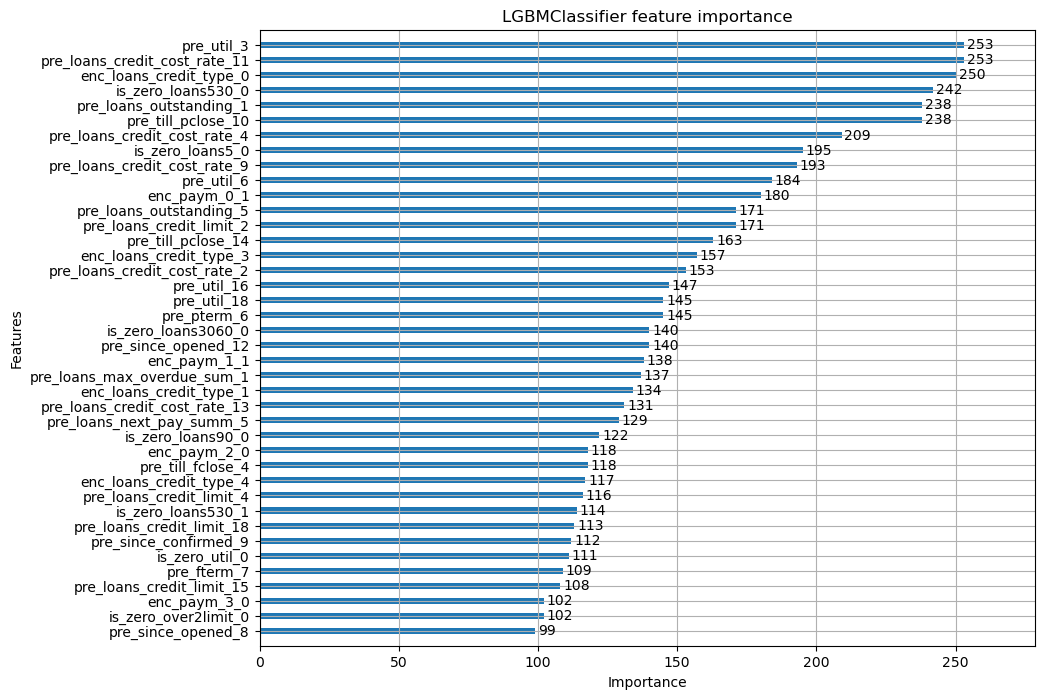

In [12]:
importances = model.feature_importances_
plot_feature_importance(features, importances, top_feats=40, title='LGBMClassifier feature importance', x_label='Importance')

In [ ]:
features = [x for x in df.columns if x not in ['id', 'flag']]
tuples = [(name, round(score, 3)) for name, score in zip(features, importances)]
tuples = sorted(tuples, key=lambda x: x[1], reverse=True)
sorted_best_features = [elem[0] for elem in tuples]
start_len_features = 434 # int(len(features) / 2)
stop_len_features = len(features)
slice = 1

for len_features in np.arange(start_len_features, stop_len_features, slice):
    print(f'------------------в {datetime.datetime.now().time()} расчет для len_features={len_features} результаты:------------------')
    slice_features = features[:len_features]
    targets = df['flag']
    cv = KFold(n_splits=5, random_state=842, shuffle=True)
    cv_preds, train_preds = np.zeros(len(df[slice_features])), np.zeros(len(df[slice_features]))
    models = []
    params = {}

    for fold, (train_id_x, cv_id_x) in enumerate(cv.split(df[slice_features], targets), 1):
        print(f'в {datetime.datetime.now().time()} тренировка фолда №{fold} начата')
        model = LGBMClassifier(class_weight='balanced', early_stopping_rounds = 250, verbose=-1, n_jobs=8, objective='binary', metric='auc', 
                               learning_rate=0.05, max_depth=20, n_estimators=1000, num_leaves=50)
        df_train_cv, df_cv = df.iloc[train_id_x], df.iloc[cv_id_x]
        model.fit(df_train_cv[slice_features], df_train_cv['flag'], eval_set=[(df_cv[slice_features], df_cv['flag'])])
   
        cv_preds[cv_id_x] = model.predict_proba(df_cv[slice_features])[:, 1]
        train_preds[train_id_x] += model.predict_proba(df_train_cv[slice_features])[:, 1] / (cv.n_splits-1)
        models.append(model)
        print(f'в {datetime.datetime.now().time()} тренировка фолда №{fold} завершена')
    print(f'train_roc_auc_score={round(roc_auc_score(targets, train_preds), 5)}, CV_roc_auc_score={round(roc_auc_score(targets, cv_preds), 5)}')

#best model: LGBMClassifier(class_weight='balanced', early_stopping_rounds=250, verbose=-1, n_jobs=8,
#learning_rate=0.05, max_depth=10, metric='auc', n_estimators=1000, num_leaves=50, objective='binary'):
#sum() c Std(): #train_roc_auc_score=0.79498, CV_roc_auc_score=0.76204

In [13]:
#лучшие 440 фич, прирост 
features = [x for x in df.columns if x not in ['id', 'flag']]
tuples = [(name, round(score, 3)) for name, score in zip(features, importances)]
tuples = sorted(tuples, key=lambda x: x[1], reverse=True)
sorted_best_features = [elem[0] for elem in tuples]
best_440_columns = sorted_best_features[:440]
df[best_440_columns][:1].to_csv(f'{path}/df_1_row_best_440_columns.csv', index=False)

#### 3.7.2.Logs Feature engineering. Поиск оптимального количества фич (без Std)

#### 3.7.2.Logs Feature engineering. Поиск оптимального количества фич

## 4. Modeling

In [21]:
df[:2]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58,id,flag
0,0.0,0.281738,0.419678,0.541016,0.657715,0.773926,0.893066,1.017578,1.147461,1.286133,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,0,0
1,0.0,0.281738,0.419678,0.541016,0.657715,0.773926,0.893066,1.017578,1.147461,1.286133,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,1,0


### 4.1 Modeling. Best parameters
- проверить варианты с/без counts_features
- проверить лучшую модель с/без StdScal()

In [ ]:
features = [x for x in df.columns if x not in ['id', 'flag']]
Xtrain, Xtest, ytrain, ytest = train_test_split(df[features], df['flag'], train_size=0.8, random_state=842)
#Xtrain, Xtest, ytrain, ytest = train_test_split(df[best_300_columns], df['flag'], train_size=0.8, random_state=842)

models = [LogisticRegression(class_weight='balanced'),
          LGBMClassifier(class_weight='balanced', early_stopping_rounds=250, verbose=-1, n_jobs=8, objective='binary', metric='auc')
          #,RandomForestClassifier(class_weight='balanced')
                ]
parameters = [{'C':np.arange(10, 10.1, 2)},
              {'learning_rate': [0.05], 'max_depth': np.arange(25,31,5), 
               'num_leaves':np.arange(65,76,10), 'n_estimators': np.arange(800,901,100)}
              ,{'n_estimators' : np.arange(70,91,10), 'max_depth' : np.arange(3,7,1),
               'min_samples_leaf' : np.arange(6,9,1), 'min_samples_split' : np.arange(6,9,1)}
                ]
for model, parameter in zip(models, parameters):
    grid_clf = GridSearchCV(model, parameter, cv=3,  scoring='roc_auc', verbose=3)
    if (str(model) == ("LogisticRegression(class_weight='balanced')")) or (str(model) == ("RandomForestClassifier()")):
        grid_clf.fit(Xtrain, ytrain)
    else:
        grid_clf.fit(Xtrain, ytrain, eval_set=[(Xtest, ytest)])
    model = grid_clf.best_estimator_
    test_roc_auc_score = roc_auc_score(ytest, model.predict_proba(Xtest)[:, 1])
    print(f'best_model={model}, test_roc_auc_score={test_roc_auc_score}')

#max_depth=25, n_estimators=800, num_leaves=75   ! test_roc_auc_score=0.7629794232490872
#max_depth=20, n_estimators=1000, num_leaves=100 !test_roc_auc_score=0.7630457984686586: 0.761, 0.759, 0.761
#max_depth=25, n_estimators=900,  num_leaves=75  !test_roc_auc_score=0.7629794232490872

In [28]:
#df_train_preds = pd.DataFrame()
targets = df['flag']
features = [x for x in df.columns if x not in ['id', 'flag']]
cv = KFold(n_splits=5, random_state=842, shuffle=True)
cv_preds, train_preds = np.zeros(len(df)), np.zeros(len(df))

for fold, (train_id_x, cv_id_x) in enumerate(cv.split(df, targets), 1):
    print(f'в {datetime.datetime.now().time()} тренировка фолда №{fold} начата')
    model = LGBMClassifier(class_weight='balanced', early_stopping_rounds=500, verbose=0, n_jobs=8,
                           learning_rate=0.05, max_depth=20, metric='auc', n_estimators=500, num_leaves=100, objective='binary')
    df_train, df_cv = df.iloc[train_id_x], df.iloc[cv_id_x]
    model.fit(df_train[features], df_train['flag'], eval_set=[(df_cv[features], df_cv['flag'])])
    cv_preds[cv_id_x] = model.predict_proba(df_cv[features])[:, 1]
    train_preds[train_id_x] += model.predict_proba(df_train[features])[:, 1] / (cv.n_splits-1)
    #df_train_preds[f'{fold}'] = model.predict_proba(df_train[features])[:, 1]
    print(f'в {datetime.datetime.now().time()} тренировка фолда №{fold} завершена')
    print(f"fold={fold}, train_roc_auc_score={roc_auc_score(df_train['flag'], model.predict_proba(df_train[features])[:, 1])}") 
    print(f"fold={fold}, cv_roc_auc_score={roc_auc_score(df_cv['flag'], model.predict_proba(df_cv[features])[:, 1])}")

print(f'train_roc_auc_score={roc_auc_score(targets, train_preds)}')
print(f'CV_roc_auc_score={roc_auc_score(targets, cv_preds)}')
#10:train_roc_auc_score=0.8056364778908409, CV_roc_auc_score=0.7622744351574369
#20:train_roc_auc_score=0.80876898142419,   CV_roc_auc_score=0.7629930267225344

в 17:30:08.193778 тренировка фолда №1 начата
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
в 17:35:14.723502 тренировка фолда №1 завершена
fold=1, train_roc_auc_score=0.8080447167959726
fold=1, cv_roc_auc_score=0.7632176338273828
в 17:35:37.570281 тренировка фолда №2 начата
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
в 17:38:36.733580 тренировка фолда №2 завершена
fold=2, train_roc_auc_score=0.8049733139005917
fold=2, cv_roc_auc_score=0.7630815756162106
в 17:38:58.468007 тренировка фолда №3 начата
[LightGBM] [Warning] early_stopping_rou

In [43]:
from statistics import mean, stdev
train_roc_auc_score = [0.8080447167959726, 0.8049733139005917, 0.8096695053867904, 0.8094886732080, 0.8033475830908365]
print(f'mean={round(mean(train_roc_auc_score), 5)}, std={round(stdev(train_roc_auc_score), 5)}')

mean=0.8071, std=0.00282


In [44]:
cv_roc_auc_score = [0.7632176338273828, 0.7630815756162106, 0.7636533250009397, 0.7605208511981687, 0.7645236432251971]
print(f'mean={round(mean(cv_roc_auc_score), 5)}, std={round(stdev(cv_roc_auc_score), 5)}')

mean=0.763, std=0.0015


### 4.1.Logs Modeling. Best parameters GridSearchCV

### 4.1.Logs Modeling. Best parameters best model

#### 4.1.Архив Modeling. Best parameters GridSearchCV
- sum() + count()
- LogisticRegression(class_weight='balanced'), {'C':np.arange(0.1, 10.1, 2)}

#### 4.2.Архив Modeling. Best parameters GridSearchCV
- LGBMClassifier(class_weight='balanced', early_stopping_rounds=25, verbose=-1, n_jobs=8, objective='binary', metric='auc')
 - {'learning_rate': [0.2], 'max_depth': np.arange(5,8,1), #'learning_rate': [0.01, 0.03, 0.05], 'reg_lambda': [0,0.5,1], 
               'num_leaves':np.arange(20,101,10), 'n_estimators': np.arange(700,1500,100)},

 - LGBMClassifier(class_weight='balanced', early_stopping_rounds=25, verbose=-1, n_jobs=8, objective='binary', metric='auc')
 - {'learning_rate': [0.2], 'max_depth': np.arange(5,8,1), #'learning_rate': [0.01, 0.03, 0.05], 'reg_lambda': [0,0.5,1], 
               'num_leaves':np.arange(20,101,10), 'n_estimators': np.arange(700,1500,100)},

#### 4.3.Архив Modeling. Best parameters GridSearchCV
- RandomForestClassifier()
- {'n_estimators' : np.arange(60, 91, 10), 'max_depth' : np.arange(5, 16, 5),
   'min_samples_leaf' : np.arange(5, 10, 1), 'min_samples_split' : np.arange(5, 10, 1)}


## 5. Evaluation

In [52]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=842)
print('Размерность файла df_train', df_train.shape)
print('Размерность файла df_test', df_test.shape)

Размерность файла df_train (2400000, 479)
Размерность файла df_test (600000, 479)


In [18]:
len(best_440_columns)

440

In [53]:
df_train_cut, df_train_cv = train_test_split(df_train, train_size=0.99, random_state=842)
df_train_cv[:2]

,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,rn_10,...,pre_loans3060_6,pre_loans6090_0,pre_loans5_10,pre_loans530_5,pre_loans530_8,rn_56,rn_57,rn_58,id,flag
434905,0.0,0.281738,0.419678,0.541016,0.657715,0.773926,0.893066,1.017578,1.147461,1.286133,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,434905,0
329458,0.0,0.281738,0.419678,0.541016,0.657715,0.773926,0.893066,1.017578,1.147461,1.286133,...,-0.001414,-0.000577,-0.000577,-0.001291,-0.001,-0.000577,-0.000577,-0.000577,329458,0


In [54]:
df_train_cut.shape[0]+df_train_cv.shape[0]+df_test.shape[0]

3000000

In [55]:
model = LGBMClassifier(class_weight='balanced', early_stopping_rounds=500, verbose=-1, n_jobs=8,
                       learning_rate=0.05, max_depth=20, metric='auc', n_estimators=500, num_leaves=100, objective='binary')

model.fit(df_train_cut[features], df_train_cut['flag'], eval_set=[(df_train_cv[features], df_train_cv['flag'])])     
score = roc_auc_score(df_test['flag'], model.predict_proba(df_test[features])[:, 1])
print(f'roc_auc_score={score}')

roc_auc_score=0.7633721489314913


In [32]:
df_test_predict = pd.DataFrame()
df_test_predict['flag'] = df_test['flag']
df_test_predict['predict_flag'] = model.predict(df_test[features])
df_test_predict[:2]

,flag,predict_flag
459980,0,0
2368532,0,0


In [29]:
len(df_test_predict)

600000

In [33]:
df_test_predict.to_csv(f'{path}/df_test_predict.csv', index=False)

### 5.1. ROC AUC

In [68]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

LGBMClassifier: ROC AUC=0.76337


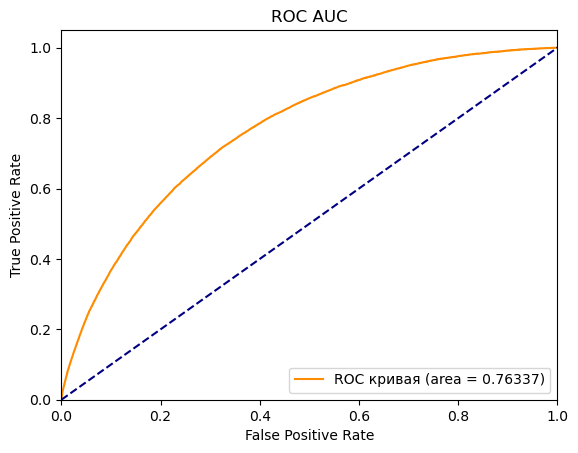

In [86]:
lr_probs = model.predict_proba(df_test[features])
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(df_test['flag'], lr_probs)
print('LGBMClassifier: ROC AUC=%.5f' % (lr_auc))
fpr, tpr, treshold = roc_curve(df_test['flag'], lr_probs, pos_label=None)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC кривая (area = %0.5f)' % lr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

## 6. Deployment
- fit.py для обучения модели
- predict.py для предсказания